In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[AI lifts paychecks for CIOs.](https://www.wsj.com/articles/artificial-intelligence-boom-lifts-paychecks-for-cios-e1527eab)

___

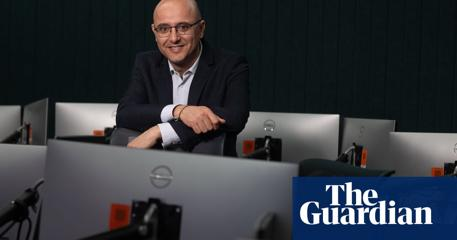

[Phone companies divert scam calls to AI bots. The future is weird.](https://www.theguardian.com/technology/article/2024/jul/07/ai-chatbots-phone-scams) - the Guardian

___

[NYT says SpaceX runs roughshod over environmental protections at Texas facility.](https://www.nytimes.com/2024/07/07/us/politics/spacex-wildlife-texas.html)

___

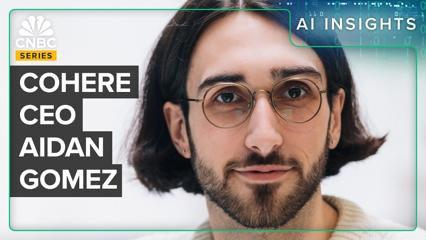

[Aiden Gomez of Cohere, fresh off of raising from Nvidia at a \\$5b valuation, says scale laws will keep on bearing fruit and progress will only get faster.](https://www.youtube.com/watch?v=ZFmapxYBafY) - YouTube

___

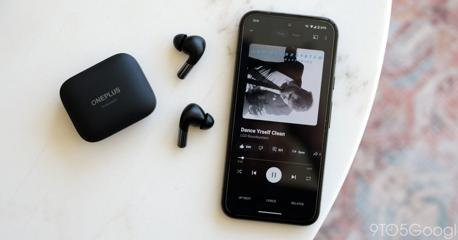

[YouTube testing AI DJ.](https://9to5google.com/2024/07/07/youtube-music-ai-radio/) - 9to5Google

___

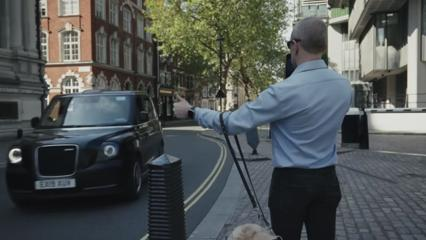

[AI is a boon for accessibility.](https://www.cnn.com/2024/07/08/tech/ai-assistive-technology-disabilities) - CNN

___

[Judge dismisses a chunk of lawsuit against GitHub and OpenAI for training the GitHub Copilot code assistant, because plaintiffs didn't show that Copilot exactly duplicated or infringed on any of their code.](https://cointelegraph.com/news/judge-dismisses-coders-dmca-claims-microsoft-open-ai-artificial-intelligence-git-hub)

___

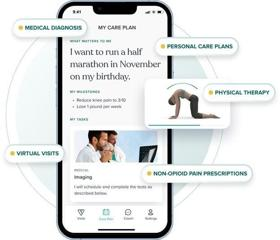

[AI could also help get patients to the right specialist faster.](https://www.forbes.com/sites/stephenwunker/2024/07/08/how-ai-and-new-care-models-make-healthcare-easier-cheaper-and-better/) - Forbes

___

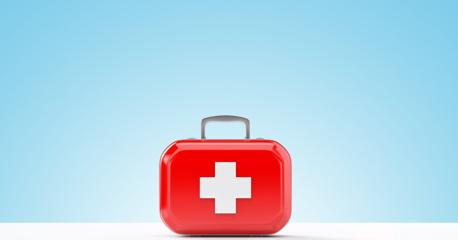

[AI and real-time monitoring via devices like continuous glucose monitors and smart watches could improve management of chronic conditions.](https://time.com/6994739/ai-behavior-change-health-care/) - TIME

___

[Les putains de Poutine se sont fait baiser, comme on dit](https://x.com/mjfree/status/1810075973272179081) - X (formerly Twitter)

___

[Dang that's quite the party in France

although in summer in France that's just a regular day in the life

www.tiktok.com/@iri.explore...](https://www.tiktok.com/@iri.explores/video/7384053813302349061?_r=1&_t=8nq8OMjrp3z)

___

[Numerous proposed bills in Congress are targeting deepfakes, including criminalizing it and allowing victims to sue.](https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/)

___

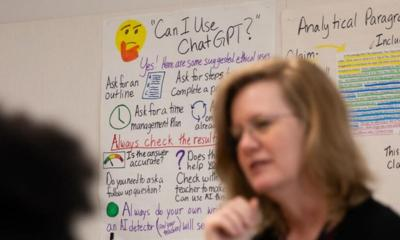

[Teachers are Using AI to Grade Papers. Who’s Grading the AI?](https://www.the74million.org/article/california-teachers-are-using-ai-to-grade-papers-whos-grading-the-ai/)

___

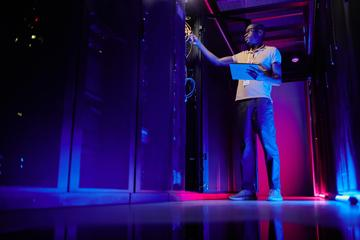

[Supermicro \\$1T? people have lost their minds](https://www.fool.com/investing/2024/07/07/1-phenomenal-stock-that-could-join-microsoft-apple/) - The Motley Fool

___

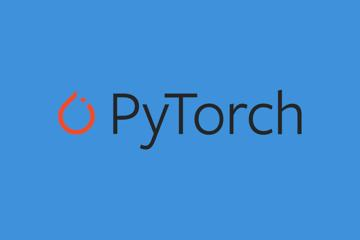

[There is a new official PyTorch documentary.](https://thenewstack.io/official-pytorch-documentary-revisits-its-past-and-its-future/) - The New Stack

___

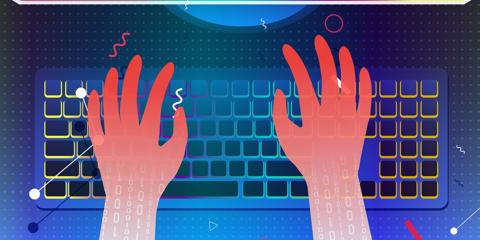

[ChatGPT is good at solving coding problems that were in LeetCode before 2021, not so good on problems from recently. (Unsurprisingly.)](https://spectrum.ieee.org/chatgpt-for-coding) - IEEE Spectrum

___

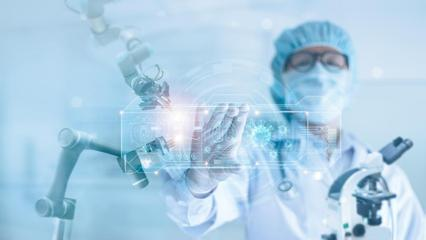

[China files way more gen-AI patents than anyone else.](https://www.yahoo.com/tech/china-beat-u-generative-ai-143730302.html) - Yahoo Tech

___

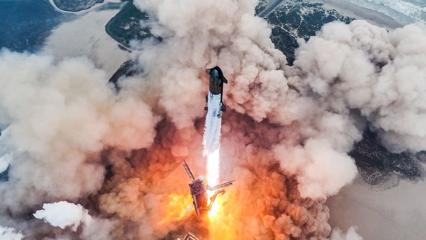

[Elon Musk says Starship to fly again and land autonomously back on its launch pad, speeding turnaround.](https://www.space.com/spacex-starship-flight-five-four-weeks-elon-musk) - Space.com

___

Otherwise AI kind of reaps without sowing, kills the golden goose, lays waste to the land in a tragedy of the commons.

We need new market frameworks and legal frameworks probably.

A better outcome would be a new social contract for search, and having a marketplace where robots could pay for specific uses in a legally and technically enforceable way. It makes economic sense for you to have a common news front page on your phone but also for the content creators to get paid.

One possible outcome of AI is, if Google summarizes sites with AI and bypasses them completely, a lot of people start  blocking robot indexers and scrapers, a lot of the Web goes dark to search. We see that already with a lot of content moving to Substacks and Discords that are invisible to search.

I don't really understand search engine economics. Google News is very good these days, and I guess news media let them scrape to get traffic and maybe converting subscribers. But then of course Google News, or Apple News, social media etc. becomes the new front page which is not great for media.

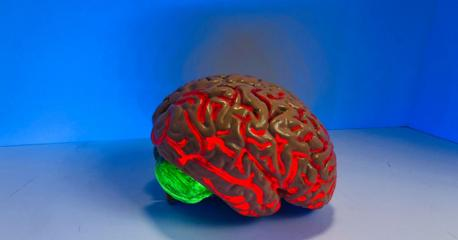

[Use mindfulness to prevent AI rewiring your brain.](https://www.psychologytoday.com/gb/blog/practical-mindfulness/202406/how-to-stop-ai-from-rewiring-your-brain-without-consent) - Psychology Today

___

[TARS GPT is so done with your bullshit.](https://www.reddit.com/r/ChatGPT/comments/1dxa77f/chatgpt_robot_is_tired_of_the_grind/)

___

[Moshi tells a bedtime story, then argues about requests to change it. It's just a story bitch!](https://www.reddit.com/r/ChatGPT/comments/1dwyhdq/moshi_gets_hilariously_frustrated_when_i_ask_to/)

___

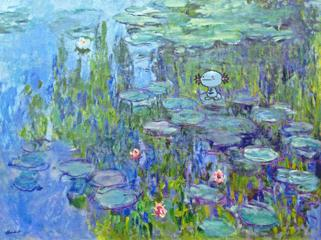

[AI ruins everything -](https://giphy.com/gifs/26gR1Sdj3SOtVPHz2)

___

[ChatGPT robots.txt disallows Anthropic and Common Crawl chatgpt.com/robots.txt](https://chatgpt.com/robots.txt)

___

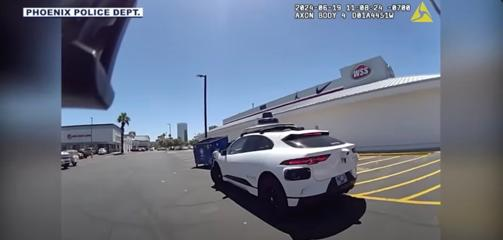

[What happens when cops pull over a troublemaking robotaxi.](https://techcrunch.com/2024/07/06/waymo-robotaxi-pulled-over-by-phoenix-police-after-driving-into-the-wrong-lane/) - TechCrunch

___

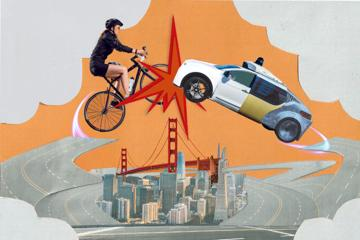

[Cyclists have mixed feelings about sharing the road with self-driving cars. Can't be worse than your average NYC garbage truck or DoorDash e-bike though.](https://www.washingtonpost.com/technology/2024/07/07/waymo-cruise-self-driving-cars-cyclist-safety/) - Washington Post

___

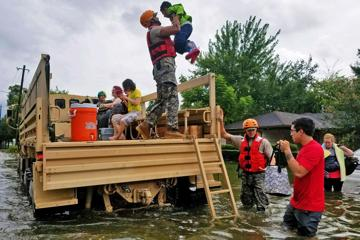

[Disaster responders use Google AI to launch drones, compare AI-matched before and after shots](https://www.forbes.com/sites/ericsiegel/2024/07/07/alphabet-uses-ai-to-rush-first-responders-to-disasters-takeaways-for-businesses/) - Forbes

___

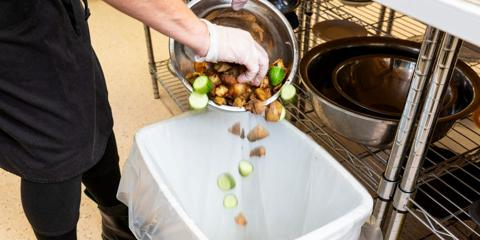

[Kitchens are turning to AI to monitor how much food they're wasting using a motion-sensor camera and scales.](https://www.businessinsider.com/hotels-offices-kitchens-winnow-ai-tool-reduce-food-waste-costs-2024-7) - Business Insider

___

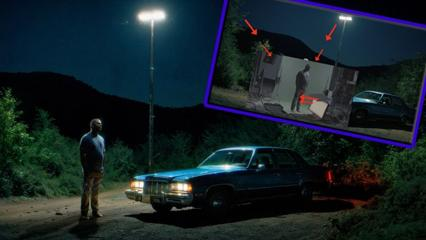

["AI is helping filmmakers with ideas that were too impractical to shoot without an exhaustive budget and wasting time on something that may not even work"](https://www.digitalcameraworld.com/features/ai-is-helping-filmmakers-with-ideas-that-were-too-impractical-to-shoot-without-an-exhaustive-budget-and-wasting-time-on-something-that-may-not-even-work) - digitalcameraworld

___

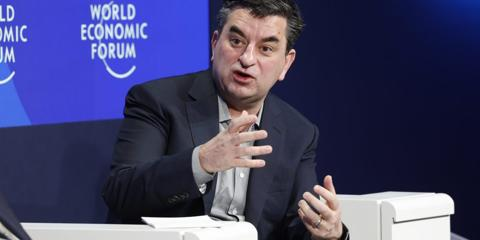

[Hedge fund giant Bridgewater launches \\$2b AI-driven fund.](https://fortune.com/2024/07/01/bridgewater-2-billion-fund-machine-learning-decision-making-openai-anthropic-perplexity/) - Fortune

___

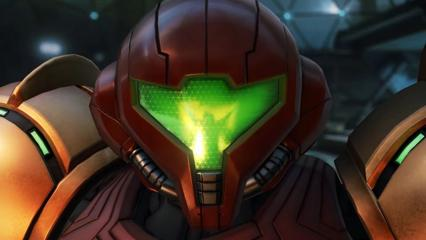

[Nintendo says no to AI for making games.](https://www.gamesradar.com/platforms/nintendo/nintendo-says-it-doesnt-need-generative-ai-to-make-games-because-it-has-decades-of-know-how-and-doesnt-want-any-issues-with-intellectual-property-rights/) - gamesradar

___

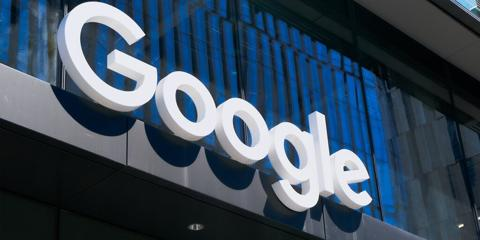

[Google trains AI faster, by curating batches IIUC.](https://decrypt.co/238730/new-ai-training-technique-is-drastically-faster-says-google) - Decrypt

___

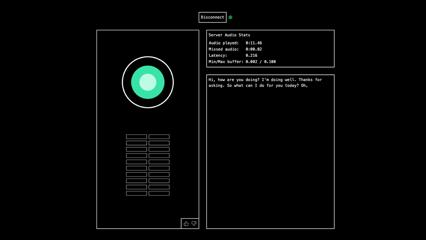

[Moshi, the French chat assistant, is a small 7b-parameter model that can run locally.](https://www.tomsguide.com/ai/moshi-chats-gpt-4o-advanced-voice-competitor-tried-to-argue-with-me-openai-doesnt-need-to-worry-just-yet) - Tom's Guide

___

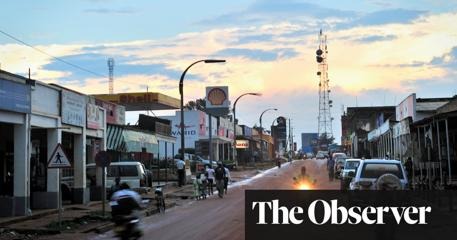

[Meet Mercy and Anita – the African workers driving the AI revolution, for just over a dollar an hour. Moderators witness suicides, torture and rape ‘almost every day … you normalise things that are just not normal’](https://www.theguardian.com/technology/article/2024/jul/06/mercy-anita-african-workers-ai-artificial-intelligence-exploitation-feeding-machine) - the Guardian

___

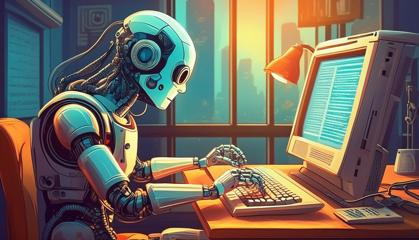

[Websim text-to-app AI turns heads.](https://www.tomsguide.com/ai/meet-websim-the-ai-playground-that-lets-you-make-anything-you-can-imagine-in-seconds) - Tom's Guide

___

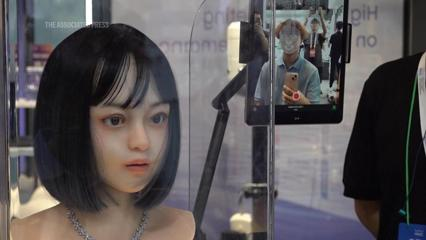

[Some of the robots seen at the Shanghai AI conference.](https://apnews.com/video/artificial-intelligence-electric-vehicles-shanghai-china-robotics-1dfcfd6e5c6142a48c3df1dd43616353) - AP News

___

[AI Dr. Doolittles are on their way.](https://mindmatters.ai/2024/07/will-ai-soon-help-animals-talk-to-us/)

___

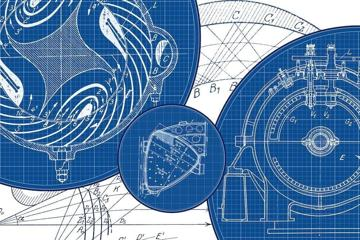

[Qdrant vector DB product combines keyword search with semantic search, which sounds right. For some searches your search engine should know that you don't want to search metaphorically.](https://www.forbes.com/sites/janakirammsv/2024/07/06/qdrant-introduces-bm42-hybrid-search-for-enhanced-rag/) - Forbes

___

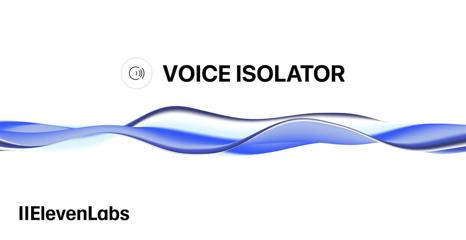

[ElevenLabs launches AI voice isolaator to clean up background noise.](https://www.maginative.com/article/elevenlabs-launches-ai-voice-isolator-to-clean-up-messy-background-noise/) - Maginative

___

[Reddit user has ChatGPT play a recent Jeopardy game, scores 47/51.](https://www.reddit.com/r/ChatGPT/comments/1dwbr1j/you_guys_remember_ibm_watson_on_jeopardy_had_gpt4/)

___

conversely if growth rate goes from 10% to 0, capex goes down 33%. they are called cyclical industries for a reason.

if rev growth rate is 5% and you replace 20% of your cap equipment each year, capex is 20+5=25% of your installed capital equipment each year, and purchases grow 5% each year. if growth rate increases to 10%. 1st year you need to buy 20% + 10% so 30%, increase of 20%, then 10% in later years.

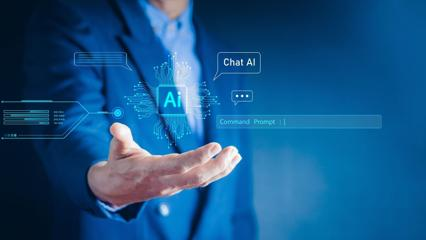

[I'm not sure I agree with this math but Sequoia is smarter than I am. Nvidia GPUs probably have a useful life of 3-4 years, should go into the calculation somewhere. There's the notion of an 'accelerator effect' in economics where an increase in the growth rate requires a brief spike in investment.](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-industry-needs-to-earn-dollar600-billion-per-year-to-pay-for-massive-hardware-spend-fears-of-an-ai-bubble-intensify-in-wake-of-sequoia-report) - Tom's Hardware

___

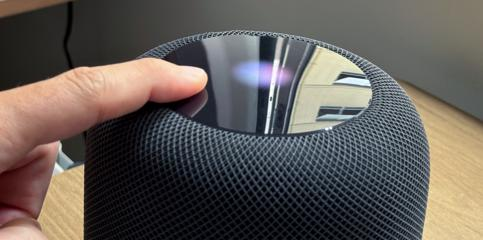

[Apple code hints at mysterious new Home Assistant device.](https://bgr.com/tech/apple-mysterious-ai-powered-home-device/) - BGR

___

[Microsoft claims text-to-speech model achieves human parity, needs as little as 3 seconds to clone someone's voice.](https://www.microsoft.com/en-us/research/project/vall-e-x/vall-e-2/)

___

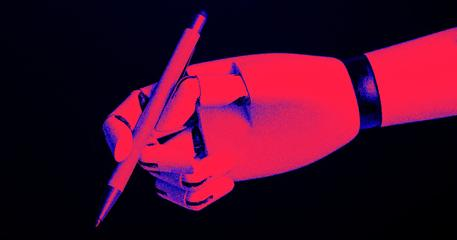

[By meticulously delving into the intricate web of AI slop, this comprehensive study takes a deep dive into overuse of certain phrases as significant risk factors enabling its detection.](https://futurism.com/the-byte/ai-overuses-specific-words) - Futurism

___

[ChatGPT can be as funny as the average human.](https://www.psypost.org/ai-outshines-humans-in-humor-study-finds-chatgpt-is-as-funny-as-the-onion/)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 8, 14, 55, 48, 672000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-07 04:57:42.181020


In [13]:
sqlite

NameError: name 'sqlite' is not defined